## Binary Classification problem (Supervised ml) | Quora Duplicate Question Pair | NLP

Dataset : Quora

Many people ask questions on Quora, and some questions are slightly different but have the same meaning. The problem is that now these similar questions exist separately, and people provide answers in two different places. Quora wants to identify these duplicate questions and merge them to enhance the user experience.

We are creating an ML model to identify which questions are similar and which ones are different.

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import re 
from bs4 import BeautifulSoup

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer

from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix

from nltk.corpus import stopwords
from fuzzywuzzy import fuzz
import distance

import warnings 
warnings.filterwarnings('ignore')

C:\Users\HP\anaconda3\lib\site-packages\fuzzywuzzy\fuzz.py:11: UserWarning: Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning
  warnings.warn('Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning')


In [2]:
df = pd.read_csv('quora.csv')

In [3]:
df

,id,qid1,qid2,question1,question2,is_duplicate
0,0,1,2,What is the step by step guide to invest in sh...,What is the step by step guide to invest in sh...,0
1,1,3,4,What is the story of Kohinoor (Koh-i-Noor) Dia...,What would happen if the Indian government sto...,0
2,2,5,6,How can I increase the speed of my internet co...,How can Internet speed be increased by hacking...,0
3,3,7,8,Why am I mentally very lonely? How can I solve...,Find the remainder when [math]23^{24}[/math] i...,0
4,4,9,10,"Which one dissolve in water quikly sugar, salt...",Which fish would survive in salt water?,0
...,...,...,...,...,...,...
404285,404285,433578,379845,How many keywords are there in the Racket prog...,How many keywords are there in PERL Programmin...,0
404286,404286,18840,155606,Do you believe there is life after death?,Is it true that there is life after death?,1
404287,404287,537928,537929,What is one coin?,What's this coin?,0
404288,404288,537930,537931,What is the approx annual cost of living while...,I am having little hairfall problem but I want...,0


In [4]:
df.shape

(404290, 6)

## Initial EDA

In [5]:
df.isnull().sum()

id              0
qid1            0
qid2            0
question1       1
question2       2
is_duplicate    0
dtype: int64

Dropped NaN rows:
There are few missing value. which is very low  so we can drop that it will not affect on datasets

In [6]:
df = df.dropna()

In [7]:
df.isnull().sum()

id              0
qid1            0
qid2            0
question1       0
question2       0
is_duplicate    0
dtype: int64

In [8]:
# not any completely duplicate row

df.duplicated().sum()

0

### Count of class labels 0 or 1

is_duplicate
0    255024
1    149263
Name: count, dtype: int64
is_duplicate
0    63.079941
1    36.920059
Name: count, dtype: float64


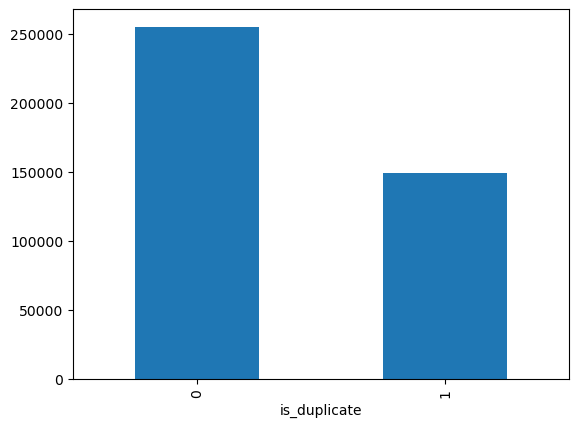

In [9]:
# Distribution of duplicate and non-duplicate questions

print(df['is_duplicate'].value_counts())
print((df['is_duplicate'].value_counts()/df['is_duplicate'].count())*100)
df['is_duplicate'].value_counts().plot(kind='bar')
plt.show()

### Number of unique and repeated questions

little imbalance datasets. towards 0 there is more datasets

In [10]:
# Repeated questions

# creates a Pandas Series and adding qid1 and qid2 using tolist() method
qid = pd.Series(df['qid1'].tolist() + df['qid2'].tolist())

print('Number of unique questions',np.unique(qid).shape[0])

x = qid.value_counts()>1
print('Number of questions getting repeated',x[x].shape[0])


Number of unique questions 537929
Number of questions getting repeated 111778


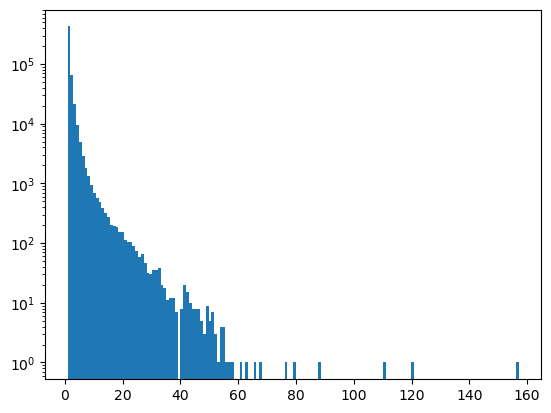

In [11]:
# Repeated questions histogram 
# this shows that how many times any question has come in the data: few questions counts are 110, 120, 160 but mostly are at 1

plt.hist(qid.value_counts().values,bins=160)
plt.yscale('log')
plt.show()

Due to the large dataset, we cannot run all 400,000 rows smoothly on this device, so we are creating a sample of 30,000 rows.
or we can use google colab as well

In [12]:
new_df = df.sample(30000, random_state=2)

In [13]:
new_df.shape

(30000, 6)

In [14]:
new_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 30000 entries, 331535 to 375293
Data columns (total 6 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   id            30000 non-null  int64 
 1   qid1          30000 non-null  int64 
 2   qid2          30000 non-null  int64 
 3   question1     30000 non-null  object
 4   question2     30000 non-null  object
 5   is_duplicate  30000 non-null  int64 
dtypes: int64(4), object(2)
memory usage: 1.6+ MB


In [15]:
# missing values
new_df.isnull().sum()

id              0
qid1            0
qid2            0
question1       0
question2       0
is_duplicate    0
dtype: int64

In [16]:
# duplicate rows
new_df.duplicated().sum()

0

is_duplicate
0    18834
1    11166
Name: count, dtype: int64
is_duplicate
0    62.78
1    37.22
Name: count, dtype: float64


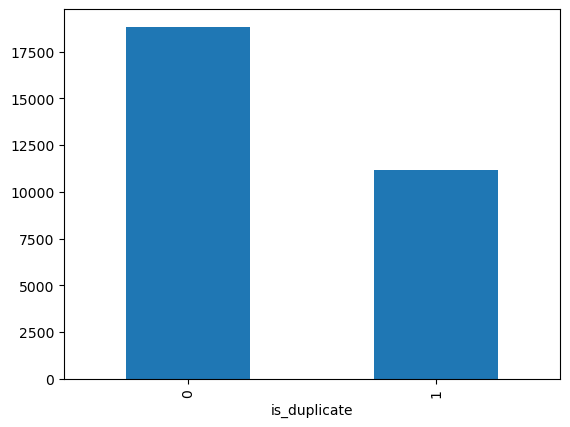

In [17]:
# Distribution of duplicate and non-duplicate questions

print(new_df['is_duplicate'].value_counts())
print((new_df['is_duplicate'].value_counts()/new_df['is_duplicate'].count())*100)
new_df['is_duplicate'].value_counts().plot(kind='bar')
plt.show()

In [18]:
# Repeated questions

qid = pd.Series(new_df['qid1'].tolist() + new_df['qid2'].tolist())
print('Number of unique questions',np.unique(qid).shape[0])
x = qid.value_counts()>1
print('Number of questions getting repeated',x[x].shape[0])

Number of unique questions 55311
Number of questions getting repeated 3485


In [19]:
# qid

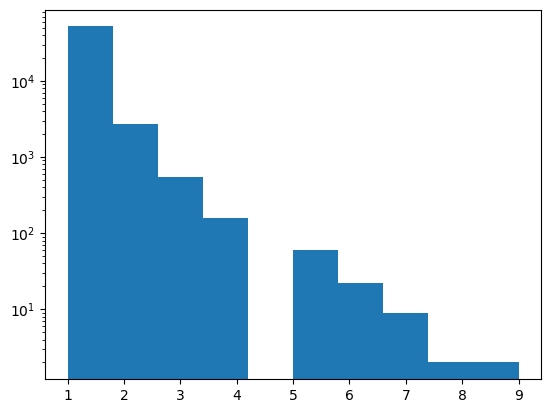

In [20]:
# Repeated questions histogram

plt.hist(qid.value_counts().values,bins=10)
plt.yscale('log')
plt.show()

In [21]:
new_df.head(10)

,id,qid1,qid2,question1,question2,is_duplicate
331535,331535,169053,295926,How can I learn Norwegian?,What is the quickest way to learn Norwegian?,1
45407,45407,81383,81384,How are currency rates determined?,Where and how are exchange rates determined?,1
286200,286200,285024,406729,What is substitution?,What is a substitute for caciocavallo?,0
157195,157195,245856,245857,How can I make iPhone 4s faster with IOS 9.2?,I have an iPhone 4S. How do I make it faster a...,1
154346,154346,242075,242076,How can I help my girlfriend cope with her par...,What can I do to help my girlfriend through he...,1
209038,209038,313198,7103,"A photon leaves the sun, bounces off a leaf, t...","A photon leaves the sun, hits a leaf, hits my ...",1
181853,181853,278486,220148,A fair six-sided die is rolled 20 times. What ...,What is the probability of getting the number ...,0
122432,122432,198162,198163,Are prunes more likely to make you poop than o...,Is it true that prune juice helps you overcome...,0
170383,170383,31455,100371,What do you think of surgical strike against P...,What world nations think about the surgical st...,1
76414,76414,56778,5215,If vacuum gravitational and dark energy are cr...,If dark energy is being created with expansion...,1


In [22]:
#created new dataframe of question1 and question1

ques_df = new_df[['question1','question2']]
ques_df.head()

,question1,question2
331535,How can I learn Norwegian?,What is the quickest way to learn Norwegian?
45407,How are currency rates determined?,Where and how are exchange rates determined?
286200,What is substitution?,What is a substitute for caciocavallo?
157195,How can I make iPhone 4s faster with IOS 9.2?,I have an iPhone 4S. How do I make it faster a...
154346,How can I help my girlfriend cope with her par...,What can I do to help my girlfriend through he...


# Bag of Words

Now we are going to apply CountVectorizer without doing any feature engineering.

PROs:
 1. BOW is simple and intutive
 2. resolved fixed input size as happen in OHE
 3. resolved out of vocabulary
 4. can recapture semantic relationship better than OHE and tfidf

CONs:
  1. saprscity (more 0 values)
  2. may overfitting
  3. ignoring odering

In [23]:
# merge texts
questions = list(ques_df['question1']) + list(ques_df['question2'])

cv = CountVectorizer(max_features=3000)
# taking max_features 3000 to reduce columns because it was reaching to 20000
# so we are taking most used 3000 columns

# now we transform the question using cv then vertical splitting the aray to q1_arr(30000) and q2_arr(30000)
q1_arr, q2_arr = np.vsplit(cv.fit_transform(questions).toarray(),2)

(30k rows) and (3k cols for bow q1 and 3k cools for bow q2) so (30000, 6000) after concat both

In [24]:
temp_df1 = pd.DataFrame(q1_arr, index= ques_df.index)
temp_df2 = pd.DataFrame(q2_arr, index= ques_df.index)

temp_df = pd.concat([temp_df1, temp_df2], axis=1)

print(temp_df.shape)
temp_df

(30000, 6000)


,0,1,2,3,4,5,6,7,8,9,...,2990,2991,2992,2993,2994,2995,2996,2997,2998,2999
331535,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
45407,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
286200,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
157195,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
154346,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
91979,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
125045,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
313995,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
203571,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [25]:
# adding new cols is_dublicate to this df

temp_df['is_duplicate'] = new_df['is_duplicate']
temp_df.head()

,0,1,2,3,4,5,6,7,8,9,...,2991,2992,2993,2994,2995,2996,2997,2998,2999,is_duplicate
331535,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
45407,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
286200,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
157195,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
154346,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1


## Model testing without Preprocessing

now are going to apply RandomForestClassifier, XGBClassifier,LogisticRegression and DecisionTreeClassifier model without doing preprocessing to see the model performance

Train and Test Construction:
We build a randomly splitted data with 80:20 train:test ratio

In [26]:
X_train,X_test,y_train,y_test = train_test_split(temp_df.iloc[:,0:-1].values,temp_df.iloc[:,-1].values,test_size=0.2,random_state=1)

In [27]:
rf = RandomForestClassifier()
rf.fit(X_train,y_train)
y_pred = rf.predict(X_test)
accuracy_score(y_test,y_pred)

0.7365

In [28]:
xgb = XGBClassifier()
xgb.fit(X_train,y_train)
y_pred = xgb.predict(X_test)
accuracy_score(y_test,y_pred)

0.7258333333333333

In [29]:
lr = LogisticRegression()
lr.fit(X_train, y_train)
y_pred = lr.predict(X_test)
accuracy_score(y_test, y_pred)

0.6995

In [30]:
dt = DecisionTreeClassifier(class_weight = 'balanced',max_leaf_nodes = None)
dt.fit(X_train,y_train)
y_pred = dt.predict(X_test)
accuracy_score(y_test,y_pred)

0.6718333333333333

After applying all Ml model we get maximum 0.74 % accuracy score without doing any advance preprocessing 

## Advance Preprocessing

Preprocessing:

 1. lower down and removing unwanted spaces by strip() and lower() func.
 2. Removing special characters and replace certain special characters with their string equivalents.
 3. Removing HTML tags using BeautifulSoup
 4. Remove punctuations by regex lib.

In [31]:
def preprocess(q):
    q = str(q).lower().strip()
    
    # Replace certain special characters with their string equivalents
    q = q.replace('%', ' percent')
    q = q.replace('$', ' dollar ')
    q = q.replace('₹', ' ruppe ')
    q = q.replace('€', ' euro ')
    q = q.replace('@', ' at ')
    
    # The pattern '[math]' appears around 900 times in the whole dataset.
    q = q.replace('[math]', '')
    
    # Replacing some numbers with string equivalents (not perfect, can be done better to account for more cases)
    q = q.replace(',000,000,000 ', 'b ')
    q = q.replace(',000,000 ', 'm ')
    q = q.replace(',000 ', 'k ')
    q = re.sub(r'([0-9]+)000000000', r'\1b', q)
    q = re.sub(r'([0-9]+)000000', r'\1m', q)
    q = re.sub(r'([0-9]+)000', r'\1k', q)
        
    # Decontracting words
    # https://en.wikipedia.org/wiki/Wikipedia%3aList_of_English_contractions
    # https://stackoverflow.com/a/19794953 
    contractions = { 
    "ain't": "am not",
    "aren't": "are not",
    "can't": "can not",
    "can't've": "can not have",
    "'cause": "because",
    "could've": "could have",
    "couldn't": "could not",
    "couldn't've": "could not have",
    "didn't": "did not",
    "doesn't": "does not",
    "don't": "do not",
    "hadn't": "had not",
    "hadn't've": "had not have",
    "hasn't": "has not",
    "haven't": "have not",
    "he'd": "he would",
    "he'd've": "he would have",
    "he'll": "he will",
    "he'll've": "he will have",
    "he's": "he is",
    "how'd": "how did",
    "how'd'y": "how do you",
    "how'll": "how will",
    "how's": "how is",
    "i'd": "i would",
    "i'd've": "i would have",
    "i'll": "i will",
    "i'll've": "i will have",
    "i'm": "i am",
    "i've": "i have",
    "isn't": "is not",
    "it'd": "it would",
    "it'd've": "it would have",
    "it'll": "it will",
    "it'll've": "it will have",
    "it's": "it is",
    "let's": "let us",
    "ma'am": "madam",
    "mayn't": "may not",
    "might've": "might have",
    "mightn't": "might not",
    "mightn't've": "might not have",
    "must've": "must have",
    "mustn't": "must not",
    "mustn't've": "must not have",
    "needn't": "need not",
    "needn't've": "need not have",
    "o'clock": "of the clock",
    "oughtn't": "ought not",
    "oughtn't've": "ought not have",
    "shan't": "shall not",
    "sha'n't": "shall not",
    "shan't've": "shall not have",
    "she'd": "she would",
    "she'd've": "she would have",
    "she'll": "she will",
    "she'll've": "she will have",
    "she's": "she is",
    "should've": "should have",
    "shouldn't": "should not",
    "shouldn't've": "should not have",
    "so've": "so have",
    "so's": "so as",
    "that'd": "that would",
    "that'd've": "that would have",
    "that's": "that is",
    "there'd": "there would",
    "there'd've": "there would have",
    "there's": "there is",
    "they'd": "they would",
    "they'd've": "they would have",
    "they'll": "they will",
    "they'll've": "they will have",
    "they're": "they are",
    "they've": "they have",
    "to've": "to have",
    "wasn't": "was not",
    "we'd": "we would",
    "we'd've": "we would have",
    "we'll": "we will",
    "we'll've": "we will have",
    "we're": "we are",
    "we've": "we have",
    "weren't": "were not",
    "what'll": "what will",
    "what'll've": "what will have",
    "what're": "what are",
    "what's": "what is",
    "what've": "what have",
    "when's": "when is",
    "when've": "when have",
    "where'd": "where did",
    "where's": "where is",
    "where've": "where have",
    "who'll": "who will",
    "who'll've": "who will have",
    "who's": "who is",
    "who've": "who have",
    "why's": "why is",
    "why've": "why have",
    "will've": "will have",
    "won't": "will not",
    "won't've": "will not have",
    "would've": "would have",
    "wouldn't": "would not",
    "wouldn't've": "would not have",
    "y'all": "you all",
    "y'all'd": "you all would",
    "y'all'd've": "you all would have",
    "y'all're": "you all are",
    "y'all've": "you all have",
    "you'd": "you would",
    "you'd've": "you would have",
    "you'll": "you will",
    "you'll've": "you will have",
    "you're": "you are",
    "you've": "you have"
    }
    
    q_decontracted = []

    for word in q.split():
        if word in contractions:
            word = contractions[word]

        q_decontracted.append(word)
    
    q = ' '.join(q_decontracted)
    q = q.replace("'ve", " have")
    q = q.replace("n't", " not")
    q = q.replace("'re", " are")
    q = q.replace("'ll", " will")
    
    # Removing HTML tags
    q = BeautifulSoup(q)
    q = q.get_text()
    
    # Remove punctuations
    pattern = re.compile('\W')
    q = re.sub(pattern, ' ', q).strip()

    return q

In [32]:
preprocess("I've already! wasn't <b>done</b>?")

'i have already  was not done'

In [33]:
new_df['question1'] = new_df['question1'].apply(preprocess)
new_df['question2'] = new_df['question2'].apply(preprocess)

new_df.head()

,id,qid1,qid2,question1,question2,is_duplicate
331535,331535,169053,295926,how can i learn norwegian,what is the quickest way to learn norwegian,1
45407,45407,81383,81384,how are currency rates determined,where and how are exchange rates determined,1
286200,286200,285024,406729,what is substitution,what is a substitute for caciocavallo,0
157195,157195,245856,245857,how can i make iphone 4s faster with ios 9 2,i have an iphone 4s how do i make it faster a...,1
154346,154346,242075,242076,how can i help my girlfriend cope with her par...,what can i do to help my girlfriend through he...,1


# Basic Feature Engineering

1. q1_len - length of question 1
2. q2_len - length of question 2
3. q1_num_words - no. of word in question 1  
4. q2_num_words - no. of word in question 2  
5. word_common - no. of common words 
6. word_total - total no. of words
7. wordr_share - world_common / world_total

In [34]:
#calculating length of questions

new_df['q1_len'] = new_df['question1'].str.len()
new_df['q2_len'] = new_df['question2'].str.len()

new_df.head()

,id,qid1,qid2,question1,question2,is_duplicate,q1_len,q2_len
331535,331535,169053,295926,how can i learn norwegian,what is the quickest way to learn norwegian,1,25,43
45407,45407,81383,81384,how are currency rates determined,where and how are exchange rates determined,1,33,43
286200,286200,285024,406729,what is substitution,what is a substitute for caciocavallo,0,20,37
157195,157195,245856,245857,how can i make iphone 4s faster with ios 9 2,i have an iphone 4s how do i make it faster a...,1,44,72
154346,154346,242075,242076,how can i help my girlfriend cope with her par...,what can i do to help my girlfriend through he...,1,58,63


In [35]:
# calculating no. of words in a question

new_df['q1_num_words'] = new_df['question1'].apply(lambda row: len(row.split(" ")))
new_df['q2_num_words'] = new_df['question2'].apply(lambda row: len(row.split(" ")))

new_df.head()

,id,qid1,qid2,question1,question2,is_duplicate,q1_len,q2_len,q1_num_words,q2_num_words
331535,331535,169053,295926,how can i learn norwegian,what is the quickest way to learn norwegian,1,25,43,5,8
45407,45407,81383,81384,how are currency rates determined,where and how are exchange rates determined,1,33,43,5,7
286200,286200,285024,406729,what is substitution,what is a substitute for caciocavallo,0,20,37,3,6
157195,157195,245856,245857,how can i make iphone 4s faster with ios 9 2,i have an iphone 4s how do i make it faster a...,1,44,72,11,17
154346,154346,242075,242076,how can i help my girlfriend cope with her par...,what can i do to help my girlfriend through he...,1,58,63,11,12


In [36]:
# calculating no. of common words in both question
def common_words(row):
    w1 = set(map(lambda word: word.lower().strip(), row['question1'].split(" ")))
    w2 = set(map(lambda word: word.lower().strip(), row['question2'].split(" ")))    
    return len(w1 & w2)

new_df['word_common'] = new_df.apply(common_words, axis=1)
new_df.head()

,id,qid1,qid2,question1,question2,is_duplicate,q1_len,q2_len,q1_num_words,q2_num_words,word_common
331535,331535,169053,295926,how can i learn norwegian,what is the quickest way to learn norwegian,1,25,43,5,8,2
45407,45407,81383,81384,how are currency rates determined,where and how are exchange rates determined,1,33,43,5,7,4
286200,286200,285024,406729,what is substitution,what is a substitute for caciocavallo,0,20,37,3,6,2
157195,157195,245856,245857,how can i make iphone 4s faster with ios 9 2,i have an iphone 4s how do i make it faster a...,1,44,72,11,17,6
154346,154346,242075,242076,how can i help my girlfriend cope with her par...,what can i do to help my girlfriend through he...,1,58,63,11,12,8


In [37]:
# calcultaing total no. of words in both of question
def total_words(row):
    w1 = set(map(lambda word: word.lower().strip(), row['question1'].split(' ')))
    w2 = set(map(lambda word: word.lower().strip(), row['question2'].split(' ')))    
    return (len(w1) + len(w2))

new_df['word_total'] = new_df.apply(total_words, axis =1)
new_df.head()

,id,qid1,qid2,question1,question2,is_duplicate,q1_len,q2_len,q1_num_words,q2_num_words,word_common,word_total
331535,331535,169053,295926,how can i learn norwegian,what is the quickest way to learn norwegian,1,25,43,5,8,2,13
45407,45407,81383,81384,how are currency rates determined,where and how are exchange rates determined,1,33,43,5,7,4,12
286200,286200,285024,406729,what is substitution,what is a substitute for caciocavallo,0,20,37,3,6,2,9
157195,157195,245856,245857,how can i make iphone 4s faster with ios 9 2,i have an iphone 4s how do i make it faster a...,1,44,72,11,17,6,27
154346,154346,242075,242076,how can i help my girlfriend cope with her par...,what can i do to help my girlfriend through he...,1,58,63,11,12,8,23


In [38]:
# calculating word share as word_common / total_word
new_df['word_share'] = round(new_df['word_common']/new_df['word_total'],2)
new_df.head()

,id,qid1,qid2,question1,question2,is_duplicate,q1_len,q2_len,q1_num_words,q2_num_words,word_common,word_total,word_share
331535,331535,169053,295926,how can i learn norwegian,what is the quickest way to learn norwegian,1,25,43,5,8,2,13,0.15
45407,45407,81383,81384,how are currency rates determined,where and how are exchange rates determined,1,33,43,5,7,4,12,0.33
286200,286200,285024,406729,what is substitution,what is a substitute for caciocavallo,0,20,37,3,6,2,9,0.22
157195,157195,245856,245857,how can i make iphone 4s faster with ios 9 2,i have an iphone 4s how do i make it faster a...,1,44,72,11,17,6,27,0.22
154346,154346,242075,242076,how can i help my girlfriend cope with her par...,what can i do to help my girlfriend through he...,1,58,63,11,12,8,23,0.35


## EDA on new features 

minimum characters 1
maximum characters 315
average num of characters 58


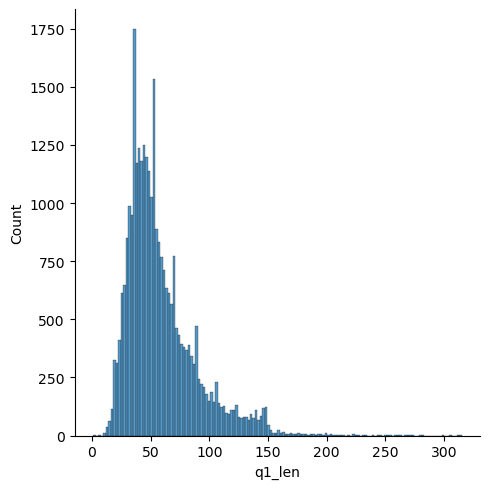

In [39]:
# distribution plot on q1_len: avg len of q is 30 to 80 and few outliers as well

sns.displot(new_df['q1_len'])
print('minimum characters',new_df['q1_len'].min())
print('maximum characters',new_df['q1_len'].max())
print('average num of characters',int(new_df['q1_len'].mean()))

minimum characters 9
maximum characters 1170
average num of characters 59


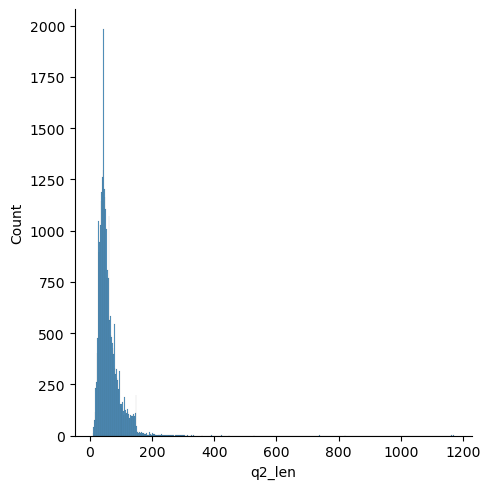

In [40]:
# distribution plot on q1_len: avg len of q is 30 to 80 and few outliers as well(1200)

sns.displot(new_df['q2_len'])
print('minimum characters',new_df['q2_len'].min())
print('maximum characters',new_df['q2_len'].max())
print('average num of characters',int(new_df['q2_len'].mean()))

minimum words 1
maximum words 74
average num of words 11


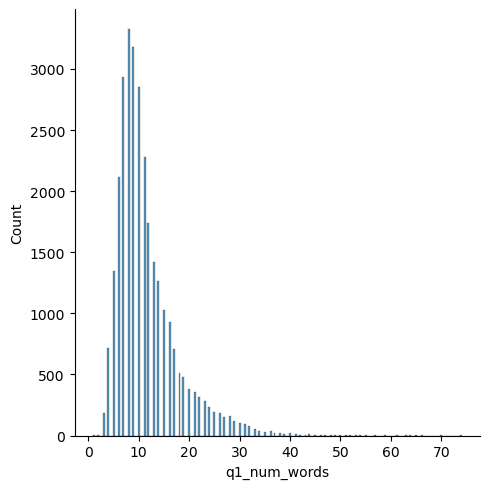

In [41]:
sns.displot(new_df['q1_num_words'])
print('minimum words',new_df['q1_num_words'].min())
print('maximum words',new_df['q1_num_words'].max())
print('average num of words',int(new_df['q1_num_words'].mean()))

minimum words 2
maximum words 270
average num of words 11


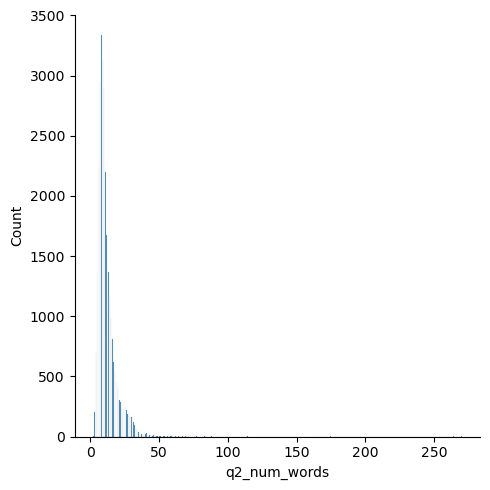

In [42]:
sns.displot(new_df['q2_num_words'])
print('minimum words',new_df['q2_num_words'].min())
print('maximum words',new_df['q2_num_words'].max())
print('average num of words',int(new_df['q2_num_words'].mean()))

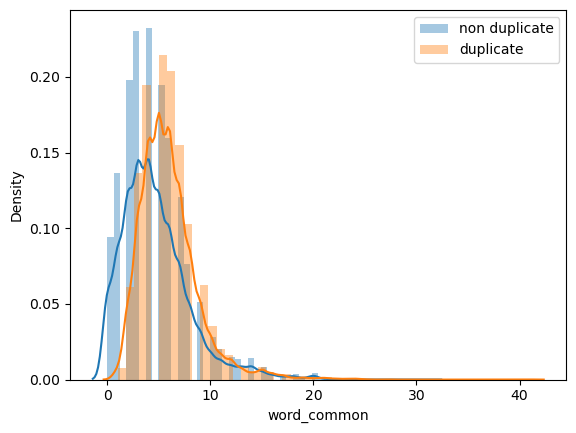

In [43]:
# EDA on common words:

sns.distplot(new_df[new_df['is_duplicate'] == 0]['word_common'],label='non duplicate')
sns.distplot(new_df[new_df['is_duplicate'] == 1]['word_common'],label='duplicate')
plt.legend()
plt.show()

when the word common is less than 3 then non duplicate possibility is more and when word share is greater than 3 
then possibilty of duplicates is more

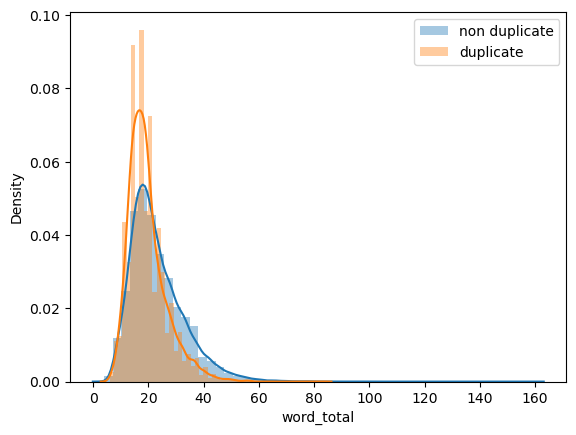

In [44]:
# EDA on total words

sns.distplot(new_df[new_df['is_duplicate'] == 0]['word_total'],label='non duplicate')
sns.distplot(new_df[new_df['is_duplicate'] == 1]['word_total'],label='duplicate')
plt.legend()
plt.show()

if the total no. of words is less than 20 then possibility of duplicate is more.
if the total no. of words is greater than 20 then the possibilty of non duplicate is more.

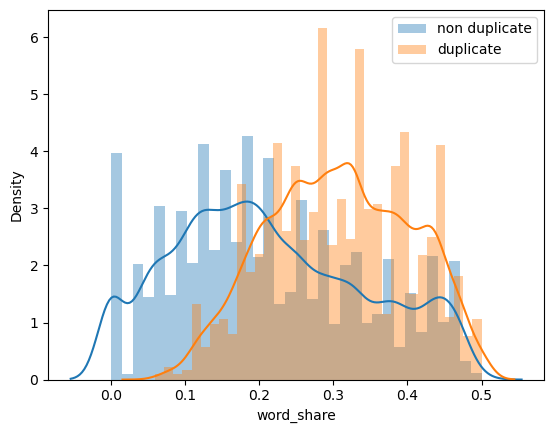

In [45]:
# EDA on word share
sns.distplot(new_df[new_df['is_duplicate'] == 0]['word_share'],label='non duplicate')
sns.distplot(new_df[new_df['is_duplicate'] == 1]['word_share'],label='duplicate')
plt.legend()
plt.show()

if the word share value is less than 0.2 then the possibility of non duplicate is more
if the word share value is greater than 0.2 then the possibility of duplicate is more

Creating final_df by adding new Features

In [46]:
ques_df =  new_df[['question1', 'question2']]
# ques_df.head()
 
final_df = new_df.drop(columns=['id','qid1','qid2','question1','question2'])
print('final_df_shape',final_df.shape)

questions = list(ques_df['question1']) + list(ques_df['question2'])
cv = CountVectorizer(max_features=3000)
q1_arr, q2_arr = np.vsplit(cv.fit_transform(questions).toarray(),2)

temp_df1 = pd.DataFrame(q1_arr, index= ques_df.index)
temp_df2 = pd.DataFrame(q2_arr, index= ques_df.index)
temp_df = pd.concat([temp_df1, temp_df2], axis=1)
print('temp_df_shape',temp_df.shape)

final_df = pd.concat([final_df, temp_df], axis=1)
print('final_df_shape',final_df.shape)
final_df.head()

final_df_shape (30000, 8)
temp_df_shape (30000, 6000)
final_df_shape (30000, 6008)


,is_duplicate,q1_len,q2_len,q1_num_words,q2_num_words,word_common,word_total,word_share,0,1,...,2990,2991,2992,2993,2994,2995,2996,2997,2998,2999
331535,1,25,43,5,8,2,13,0.15,0,0,...,0,0,0,0,0,0,0,0,0,0
45407,1,33,43,5,7,4,12,0.33,0,0,...,0,0,0,0,0,0,0,0,0,0
286200,0,20,37,3,6,2,9,0.22,0,0,...,0,0,0,0,0,0,0,0,0,0
157195,1,44,72,11,17,6,27,0.22,0,0,...,0,0,0,0,0,0,0,0,0,0
154346,1,58,63,11,12,8,23,0.35,0,0,...,0,0,0,0,0,0,0,0,0,0


In [47]:
X_train,X_test,y_train,y_test = train_test_split(final_df.iloc[:,1:].values,final_df.iloc[:,0].values,test_size=0.2,random_state=1)

In [48]:
rf = RandomForestClassifier()
rf.fit(X_train,y_train)
y_pred = rf.predict(X_test)
accuracy_score(y_test,y_pred)

0.7585

In [49]:
xgb = XGBClassifier()
xgb.fit(X_train,y_train)
y_pred = xgb.predict(X_test)
accuracy_score(y_test,y_pred)

0.7618333333333334

In [50]:
lr = LogisticRegression()
lr.fit(X_train, y_train)
y_pred = lr.predict(X_test)
accuracy_score(y_test, y_pred)

0.7353333333333333

In [51]:
dt = DecisionTreeClassifier(class_weight = 'balanced',max_leaf_nodes = None)
dt.fit(X_train,y_train)
y_pred = dt.predict(X_test)
accuracy_score(y_test,y_pred)

0.6956666666666667

## Advanced Features

A. Token Features

    1. cwc_min: This is the ratio of the number of common words to the length of the smaller question
    2. cwc_max: This is the ratio of the number of common words to the length of the larger question
    3. csc_min: This is the ratio of the number of common stop words to the smaller stop word count among the two questions
    4. csc_max: This is the ratio of the number of common stop words to the larger stop word count among the two questions
    5. ctc_min: This is the ratio of the number of common tokens to the smaller token count among the two questions
    6. ctc_max: This is the ratio of the number of common tokens to the larger token count among the two questions
    7. last_word_eq: 1 if the last word in the two questions is same, 0 otherwise
    8. first_word_eq: 1 if the first word in the two questions is same, 0 otherwise

B. Length Based Features

    9. mean_len: Mean of the length of the two questions (number of words)
    10. abs_len_diff: Absolute difference between the length of the two questions (number of words)
    11. longest_substr_ratio: Ratio of the length of the longest substring among the two questions to the length of the smaller question

C. Fuzzy Features

    12. fuzz_ratio: fuzz_ratio score from fuzzywuzzy
    13. fuzz_partial_ratio: fuzz_partial_ratio from fuzzywuzzy
    14. token_sort_ratio: token_sort_ratio from fuzzywuzzy
    15. token_set_ratio: token_set_ratio from fuzzywuzzy

In [52]:
# Advanced Features
from nltk.corpus import stopwords

def fetch_token_features(row):
    
    q1 = row['question1']
    q2 = row['question2']
    
    SAFE_DIV = 0.0001 

    STOP_WORDS = stopwords.words("english")
    
    token_features = [0.0]*8
    
    # Converting the Sentence into Tokens: 
    q1_tokens = q1.split()
    q2_tokens = q2.split()
    
    if len(q1_tokens) == 0 or len(q2_tokens) == 0:
        return token_features

    # Get the non-stopwords in Questions
    q1_words = set([word for word in q1_tokens if word not in STOP_WORDS])
    q2_words = set([word for word in q2_tokens if word not in STOP_WORDS])
    
    #Get the stopwords in Questions
    q1_stops = set([word for word in q1_tokens if word in STOP_WORDS])
    q2_stops = set([word for word in q2_tokens if word in STOP_WORDS])
    
    # Get the common non-stopwords from Question pair
    common_word_count = len(q1_words.intersection(q2_words))
    
    # Get the common stopwords from Question pair
    common_stop_count = len(q1_stops.intersection(q2_stops))
    
    # Get the common Tokens from Question pair
    common_token_count = len(set(q1_tokens).intersection(set(q2_tokens)))
    
    
    token_features[0] = common_word_count / (min(len(q1_words), len(q2_words)) + SAFE_DIV)
    token_features[1] = common_word_count / (max(len(q1_words), len(q2_words)) + SAFE_DIV)
    token_features[2] = common_stop_count / (min(len(q1_stops), len(q2_stops)) + SAFE_DIV)
    token_features[3] = common_stop_count / (max(len(q1_stops), len(q2_stops)) + SAFE_DIV)
    token_features[4] = common_token_count / (min(len(q1_tokens), len(q2_tokens)) + SAFE_DIV)
    token_features[5] = common_token_count / (max(len(q1_tokens), len(q2_tokens)) + SAFE_DIV)
    
    # Last word of both question is same or not
    token_features[6] = int(q1_tokens[-1] == q2_tokens[-1])
    
    # First word of both question is same or not
    token_features[7] = int(q1_tokens[0] == q2_tokens[0])
    
    return token_features

token_features = new_df.apply(fetch_token_features, axis=1)

new_df["cwc_min"]       = list(map(lambda x: x[0], token_features))
new_df["cwc_max"]       = list(map(lambda x: x[1], token_features))
new_df["csc_min"]       = list(map(lambda x: x[2], token_features))
new_df["csc_max"]       = list(map(lambda x: x[3], token_features))
new_df["ctc_min"]       = list(map(lambda x: x[4], token_features))
new_df["ctc_max"]       = list(map(lambda x: x[5], token_features))
new_df["last_word_eq"]  = list(map(lambda x: x[6], token_features))
new_df["first_word_eq"] = list(map(lambda x: x[7], token_features))
 
new_df.head()

,id,qid1,qid2,question1,question2,is_duplicate,q1_len,q2_len,q1_num_words,q2_num_words,...,word_total,word_share,cwc_min,cwc_max,csc_min,csc_max,ctc_min,ctc_max,last_word_eq,first_word_eq
331535,331535,169053,295926,how can i learn norwegian,what is the quickest way to learn norwegian,1,25,43,5,8,...,13,0.15,0.999950,0.499988,0.000000,0.000000,0.399992,0.249997,1,0
45407,45407,81383,81384,how are currency rates determined,where and how are exchange rates determined,1,33,43,5,7,...,12,0.33,0.666644,0.666644,0.999950,0.499988,0.799984,0.571420,1,0
286200,286200,285024,406729,what is substitution,what is a substitute for caciocavallo,0,20,37,3,6,...,9,0.22,0.000000,0.000000,0.999950,0.499988,0.666644,0.333328,0,1
157195,157195,245856,245857,how can i make iphone 4s faster with ios 9 2,i have an iphone 4s how do i make it faster a...,1,44,72,11,17,...,27,0.22,0.666656,0.571420,0.499988,0.222220,0.545450,0.374998,0,0
154346,154346,242075,242076,how can i help my girlfriend cope with her par...,what can i do to help my girlfriend through he...,1,58,63,11,12,...,23,0.35,0.999975,0.799984,0.666656,0.499994,0.727266,0.666661,1,0


In [53]:
import distance

def fetch_length_features(row):
    
    q1 = row['question1']
    q2 = row['question2']
    
    length_features = [0.0]*3
    
    # Converting the Sentence into Tokens: 
    q1_tokens = q1.split()
    q2_tokens = q2.split()
    
    if len(q1_tokens) == 0 or len(q2_tokens) == 0:
        return length_features
    
    # Absolute length features
    length_features[0] = abs(len(q1_tokens) - len(q2_tokens))
    
    #Average Token Length of both Questions
    length_features[1] = (len(q1_tokens) + len(q2_tokens))/2
    
    strs = list(distance.lcsubstrings(q1, q2))
    length_features[2] = len(strs[0]) / (min(len(q1), len(q2)) + 1)
    
    return length_features
    
length_features = new_df.apply(fetch_length_features, axis=1)

new_df['abs_len_diff'] = list(map(lambda x: x[0], length_features))
new_df['mean_len'] = list(map(lambda x: x[1], length_features))
new_df['longest_substr_ratio'] = list(map(lambda x: x[2], length_features))

new_df.head()

,id,qid1,qid2,question1,question2,is_duplicate,q1_len,q2_len,q1_num_words,q2_num_words,...,cwc_max,csc_min,csc_max,ctc_min,ctc_max,last_word_eq,first_word_eq,abs_len_diff,mean_len,longest_substr_ratio
331535,331535,169053,295926,how can i learn norwegian,what is the quickest way to learn norwegian,1,25,43,5,8,...,0.499988,0.000000,0.000000,0.399992,0.249997,1,0,3,6.5,0.615385
45407,45407,81383,81384,how are currency rates determined,where and how are exchange rates determined,1,33,43,5,7,...,0.666644,0.999950,0.499988,0.799984,0.571420,1,0,2,6.0,0.500000
286200,286200,285024,406729,what is substitution,what is a substitute for caciocavallo,0,20,37,3,6,...,0.000000,0.999950,0.499988,0.666644,0.333328,0,1,3,4.5,0.476190
157195,157195,245856,245857,how can i make iphone 4s faster with ios 9 2,i have an iphone 4s how do i make it faster a...,1,44,72,11,17,...,0.571420,0.499988,0.222220,0.545450,0.374998,0,0,5,13.5,0.244444
154346,154346,242075,242076,how can i help my girlfriend cope with her par...,what can i do to help my girlfriend through he...,1,58,63,11,12,...,0.799984,0.666656,0.499994,0.727266,0.666661,1,0,1,11.5,0.355932


# Fuzzy Features


1. fuzz_ratio: score is a numeric value that indicates how similar two strings are based on their characters and sequence of characters. It's particularly useful for tasks like record linkage, fuzzy matching, and text comparison.

2. fuzz.partial_ratio: function works by finding the best partial substring match between two strings and computing a similarity score based on that match.

3. fuzz.token_sort_ratio: function operates by tokenizing the input strings into individual words, sorting those words, and then calculating a similarity score based on the sorted word lists. This approach helps in handling cases where the same words appear in different orders in the compared strings.

4. fuzz.token_set_ratio: function operates by finding the intersection of the token sets from the two input strings and calculating a similarity score based on this intersection. It's particularly useful when you want to capture the overall similarity of the token sets while being flexible about the specific word order.

In [54]:
# Fuzzy Features
from fuzzywuzzy import fuzz

def fetch_fuzzy_features(row):
    
    q1 = row['question1']
    q2 = row['question2']
    
    fuzzy_features = [0.0]*4
    
    # fuzz_ratio
    fuzzy_features[0] = fuzz.QRatio(q1, q2)

    # fuzz_partial_ratio
    fuzzy_features[1] = fuzz.partial_ratio(q1, q2)

    # token_sort_ratio
    fuzzy_features[2] = fuzz.token_sort_ratio(q1, q2)

    # token_set_ratio
    fuzzy_features[3] = fuzz.token_set_ratio(q1, q2)

    return fuzzy_features

fuzzy_features = new_df.apply(fetch_fuzzy_features, axis=1)

# Creating new feature columns for fuzzy features
new_df['fuzz_ratio'] = list(map(lambda x: x[0], fuzzy_features))
new_df['fuzz_partial_ratio'] = list(map(lambda x: x[1], fuzzy_features))
new_df['token_sort_ratio'] = list(map(lambda x: x[2], fuzzy_features))
new_df['token_set_ratio'] = list(map(lambda x: x[3], fuzzy_features))

print(new_df.shape)
new_df.head()

(30000, 28)


,id,qid1,qid2,question1,question2,is_duplicate,q1_len,q2_len,q1_num_words,q2_num_words,...,ctc_max,last_word_eq,first_word_eq,abs_len_diff,mean_len,longest_substr_ratio,fuzz_ratio,fuzz_partial_ratio,token_sort_ratio,token_set_ratio
331535,331535,169053,295926,how can i learn norwegian,what is the quickest way to learn norwegian,1,25,43,5,8,...,0.249997,1,0,3,6.5,0.615385,59,68,50,75
45407,45407,81383,81384,how are currency rates determined,where and how are exchange rates determined,1,33,43,5,7,...,0.571420,1,0,2,6.0,0.500000,71,82,63,84
286200,286200,285024,406729,what is substitution,what is a substitute for caciocavallo,0,20,37,3,6,...,0.333328,0,1,3,4.5,0.476190,67,85,60,60
157195,157195,245856,245857,how can i make iphone 4s faster with ios 9 2,i have an iphone 4s how do i make it faster a...,1,44,72,11,17,...,0.374998,0,0,5,13.5,0.244444,45,55,61,76
154346,154346,242075,242076,how can i help my girlfriend cope with her par...,what can i do to help my girlfriend through he...,1,58,63,11,12,...,0.666661,1,0,1,11.5,0.355932,81,81,78,86


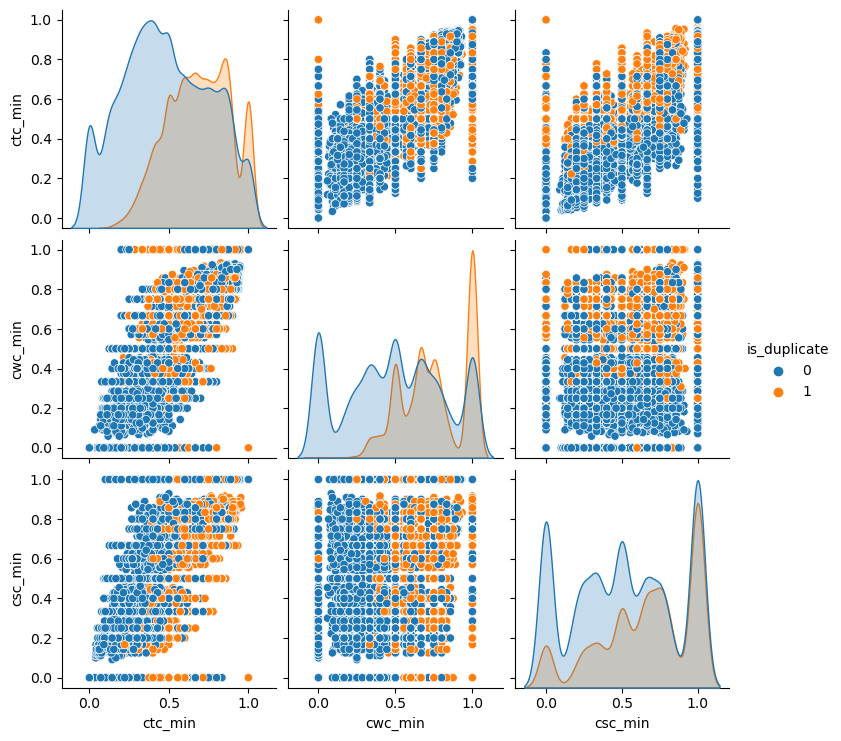

In [55]:
sns.pairplot(new_df[['ctc_min', 'cwc_min', 'csc_min', 'is_duplicate']],hue='is_duplicate')

By observing the diagonal pairplot. cleary we can see that there are few insight which can tell us about duplicate and non duplicate question 

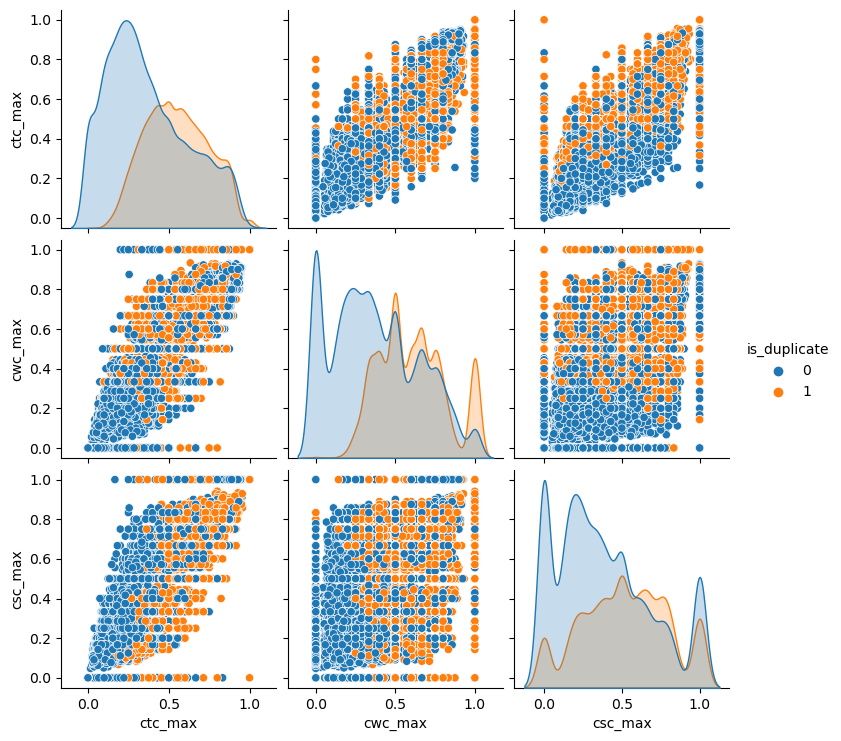

In [56]:
sns.pairplot(new_df[['ctc_max', 'cwc_max', 'csc_max', 'is_duplicate']],hue='is_duplicate')

same as upper pairplot we can use these features

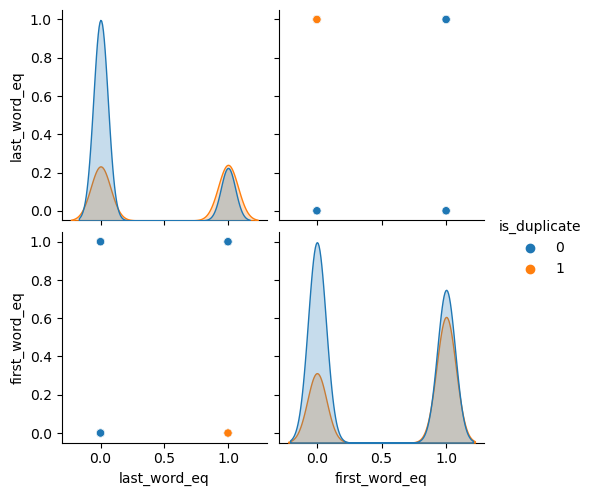

In [57]:
sns.pairplot(new_df[['last_word_eq', 'first_word_eq', 'is_duplicate']],hue='is_duplicate')

 from pairplot we can see that if first word or last word are not equal then there is probability that it is not duplicate

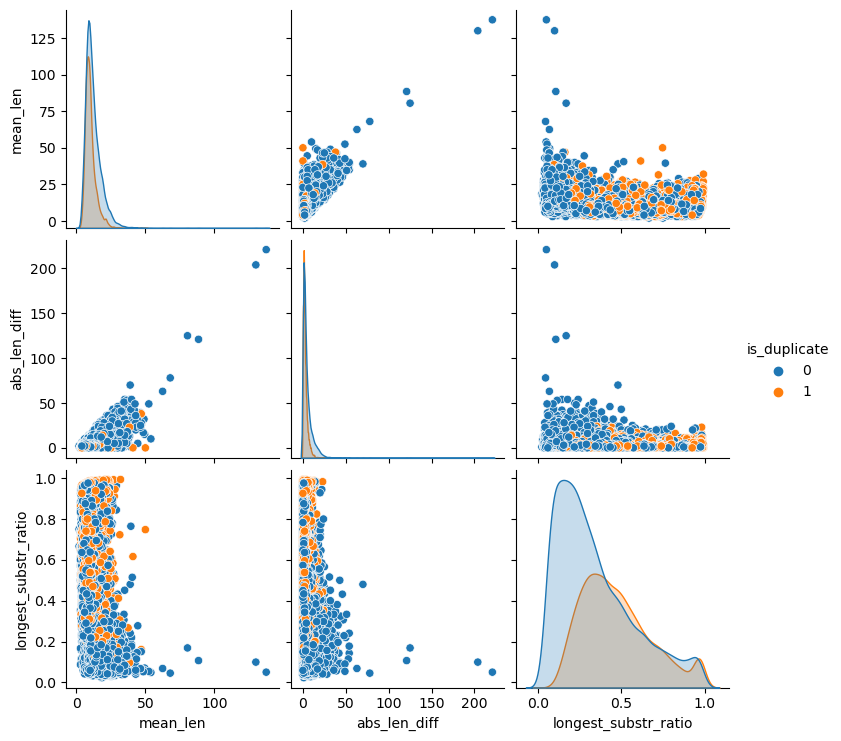

In [58]:
sns.pairplot(new_df[['mean_len', 'abs_len_diff','longest_substr_ratio', 'is_duplicate']],hue='is_duplicate')

we can see that longest_substr_ratio feature can be usefull

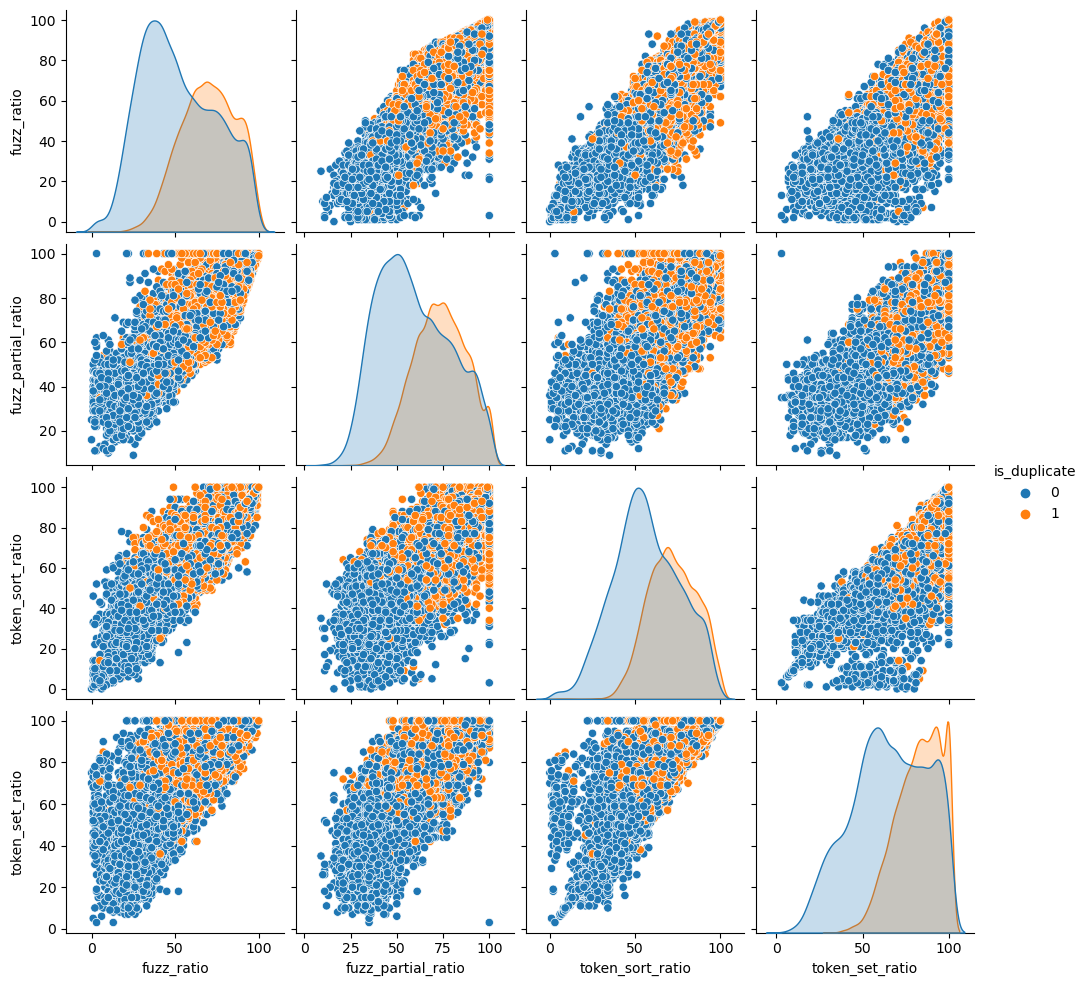

In [59]:
sns.pairplot(new_df[['fuzz_ratio', 'fuzz_partial_ratio','token_sort_ratio','token_set_ratio', 'is_duplicate']],hue='is_duplicate')

we can include all fuzz columns that everyone giving some insights

Now creating again final_df

In [60]:
ques_df = new_df[['question1', 'question2']]
print(ques_df.shape)
ques_df.head()

(30000, 2)


,question1,question2
331535,how can i learn norwegian,what is the quickest way to learn norwegian
45407,how are currency rates determined,where and how are exchange rates determined
286200,what is substitution,what is a substitute for caciocavallo
157195,how can i make iphone 4s faster with ios 9 2,i have an iphone 4s how do i make it faster a...
154346,how can i help my girlfriend cope with her par...,what can i do to help my girlfriend through he...


In [61]:
final_df = new_df.drop(columns=['id','qid1','qid2','question1','question2'])
print(final_df.shape)
final_df.head()

(30000, 23)


,is_duplicate,q1_len,q2_len,q1_num_words,q2_num_words,word_common,word_total,word_share,cwc_min,cwc_max,...,ctc_max,last_word_eq,first_word_eq,abs_len_diff,mean_len,longest_substr_ratio,fuzz_ratio,fuzz_partial_ratio,token_sort_ratio,token_set_ratio
331535,1,25,43,5,8,2,13,0.15,0.999950,0.499988,...,0.249997,1,0,3,6.5,0.615385,59,68,50,75
45407,1,33,43,5,7,4,12,0.33,0.666644,0.666644,...,0.571420,1,0,2,6.0,0.500000,71,82,63,84
286200,0,20,37,3,6,2,9,0.22,0.000000,0.000000,...,0.333328,0,1,3,4.5,0.476190,67,85,60,60
157195,1,44,72,11,17,6,27,0.22,0.666656,0.571420,...,0.374998,0,0,5,13.5,0.244444,45,55,61,76
154346,1,58,63,11,12,8,23,0.35,0.999975,0.799984,...,0.666661,1,0,1,11.5,0.355932,81,81,78,86


In [62]:
# merge texts
questions = list(ques_df['question1']) + list(ques_df['question2'])

cv = CountVectorizer(max_features=3000)
q1_arr, q2_arr = np.vsplit(cv.fit_transform(questions).toarray(),2)

In [63]:
len(questions)

60000

In [64]:
temp_df1 = pd.DataFrame(q1_arr, index = ques_df.index)
temp_df2 = pd.DataFrame(q2_arr, index = ques_df.index)
temp_df = pd.concat([temp_df1, temp_df2], axis =1)
temp_df.shape

(30000, 6000)

In [65]:
final_df = pd.concat([final_df, temp_df], axis = 1)
print(final_df.shape)
final_df.head()

(30000, 6023)


,is_duplicate,q1_len,q2_len,q1_num_words,q2_num_words,word_common,word_total,word_share,cwc_min,cwc_max,...,2990,2991,2992,2993,2994,2995,2996,2997,2998,2999
331535,1,25,43,5,8,2,13,0.15,0.999950,0.499988,...,0,0,0,0,0,0,0,0,0,0
45407,1,33,43,5,7,4,12,0.33,0.666644,0.666644,...,0,0,0,0,0,0,0,0,0,0
286200,0,20,37,3,6,2,9,0.22,0.000000,0.000000,...,0,0,0,0,0,0,0,0,0,0
157195,1,44,72,11,17,6,27,0.22,0.666656,0.571420,...,0,0,0,0,0,0,0,0,0,0
154346,1,58,63,11,12,8,23,0.35,0.999975,0.799984,...,0,0,0,0,0,0,0,0,0,0


In [66]:
X_train,X_test,y_train,y_test = train_test_split(final_df.iloc[:,1:].values,final_df.iloc[:,0].values,test_size=0.2,random_state=1)

In [70]:
rf = RandomForestClassifier()
rf.fit(X_train,y_train)
y_pred = rf.predict(X_test)
print('accuracy_score',accuracy_score(y_test, y_pred))

confusion_matrix(y_test,y_pred)

accuracy_score 0.789


array([[3199,  554],
       [ 712, 1535]], dtype=int64)

In [71]:
xgb = XGBClassifier()
xgb.fit(X_train,y_train)
y_pred1 = xgb.predict(X_test)
print('accuracy_score',accuracy_score(y_test, y_pred1))

confusion_matrix(y_test,y_pred1)

accuracy_score 0.7871666666666667


array([[3124,  629],
       [ 648, 1599]], dtype=int64)

In [74]:
lr = LogisticRegression()
lr.fit(X_train, y_train)
y_pred2 = lr.predict(X_test)
print('accuracy_score',accuracy_score(y_test, y_pred2))

confusion_matrix(y_test,y_pred2)

accuracy_score 0.7148333333333333


array([[3012,  741],
       [ 970, 1277]], dtype=int64)

In [75]:
dt = DecisionTreeClassifier(class_weight = 'balanced',max_leaf_nodes = None)
dt.fit(X_train,y_train)
y_pred3 = dt.predict(X_test)
print('accuracy_score',accuracy_score(y_test, y_pred3))

confusion_matrix(y_test,y_pred3)

accuracy_score 0.719


array([[2833,  920],
       [ 766, 1481]], dtype=int64)

In both term of accuracy score and confusion matrix: we get accuarcy of 79% and few times 80% as well and better confusion matrix than other model so we can say that RandomForestClassifier is best fit model for this project

In RandomForest the prediction of duplicate is lower than other model when they actual not duplicate. which more big problem so we can say that its confusion matrix is better than others

## How to increase the accuracy_score:

    1. Increase the data (Increase RAM, google Colab, incremental learning)
    2. More advance  preprocessing
    3. HyperParametertunning
    4. more features
    5. BOW --> TFIDF, Word2Vec
    6. crossvalidaion
    7. Deep Learning (LSTM)

# Model deployment

In [76]:
def test_common_words(q1,q2):
    w1 = set(map(lambda word : word.lower().strip(), q1.split(" ")))
    w2 = set(map(lambda word : word.lower().strip(), q2.split(" ")))    
    return len(w1 & w2)

In [77]:
def test_total_words(q1,q2):
    w1 = set(map(lambda word: word.lower().strip(), q1.split(" ")))
    w2 = set(map(lambda word: word.lower().strip(), q2.split(" ")))    
    return (len(w1) + len(w2))

In [78]:
def test_fetch_token_features(q1,q2):
    
    SAFE_DIV = 0.0001 

    STOP_WORDS = stopwords.words("english")
    
    token_features = [0.0]*8
    
    # Converting the Sentence into Tokens: 
    q1_tokens = q1.split()
    q2_tokens = q2.split()
    
    if len(q1_tokens) == 0 or len(q2_tokens) == 0:
        return token_features

    # Get the non-stopwords in Questions
    q1_words = set([word for word in q1_tokens if word not in STOP_WORDS])
    q2_words = set([word for word in q2_tokens if word not in STOP_WORDS])
    
    #Get the stopwords in Questions
    q1_stops = set([word for word in q1_tokens if word in STOP_WORDS])
    q2_stops = set([word for word in q2_tokens if word in STOP_WORDS])
    
    # Get the common non-stopwords from Question pair
    common_word_count = len(q1_words.intersection(q2_words))
    
    # Get the common stopwords from Question pair
    common_stop_count = len(q1_stops.intersection(q2_stops))
    
    # Get the common Tokens from Question pair
    common_token_count = len(set(q1_tokens).intersection(set(q2_tokens)))
    
    
    token_features[0] = common_word_count / (min(len(q1_words), len(q2_words)) + SAFE_DIV)
    token_features[1] = common_word_count / (max(len(q1_words), len(q2_words)) + SAFE_DIV)
    token_features[2] = common_stop_count / (min(len(q1_stops), len(q2_stops)) + SAFE_DIV)
    token_features[3] = common_stop_count / (max(len(q1_stops), len(q2_stops)) + SAFE_DIV)
    token_features[4] = common_token_count / (min(len(q1_tokens), len(q2_tokens)) + SAFE_DIV)
    token_features[5] = common_token_count / (max(len(q1_tokens), len(q2_tokens)) + SAFE_DIV)
    
    # Last word of both question is same or not
    token_features[6] = int(q1_tokens[-1] == q2_tokens[-1])
    
    # First word of both question is same or not
    token_features[7] = int(q1_tokens[0] == q2_tokens[0])
    
    return token_features

In [79]:
def test_fetch_length_features(q1,q2):
    
    length_features = [0.0]*3
    
    # Converting the Sentence into Tokens: 
    q1_tokens = q1.split()
    q2_tokens = q2.split()
    
    if len(q1_tokens) == 0 or len(q2_tokens) == 0:
        return length_features
    
    # Absolute length features
    length_features[0] = abs(len(q1_tokens) - len(q2_tokens))
    
    #Average Token Length of both Questions
    length_features[1] = (len(q1_tokens) + len(q2_tokens))/2
    
    strs = list(distance.lcsubstrings(q1, q2))
    length_features[2] = len(strs[0]) / (min(len(q1), len(q2)) + 1)
    
    return length_features

In [80]:
def test_fetch_fuzzy_features(q1,q2):
    
    fuzzy_features = [0.0]*4
    
    # fuzz_ratio
    fuzzy_features[0] = fuzz.QRatio(q1, q2)

    # fuzz_partial_ratio
    fuzzy_features[1] = fuzz.partial_ratio(q1, q2)

    # token_sort_ratio
    fuzzy_features[2] = fuzz.token_sort_ratio(q1, q2)

    # token_set_ratio
    fuzzy_features[3] = fuzz.token_set_ratio(q1, q2)

    return fuzzy_features

In [81]:
def query_point_creator(q1,q2):
    
    input_query = []
    
    # preprocess
    q1 = preprocess(q1)
    q2 = preprocess(q2)
    
    # fetch basic features
    input_query.append(len(q1))
    input_query.append(len(q2))
    
    input_query.append(len(q1.split(" ")))
    input_query.append(len(q2.split(" ")))
    
    input_query.append(test_common_words(q1,q2))
    input_query.append(test_total_words(q1,q2))
    input_query.append(round(test_common_words(q1,q2)/test_total_words(q1,q2),2))
    
    # fetch token features
    token_features = test_fetch_token_features(q1,q2)
    input_query.extend(token_features)
    
    # fetch length based features
    length_features = test_fetch_length_features(q1,q2)
    input_query.extend(length_features)
    
    # fetch fuzzy features
    fuzzy_features = test_fetch_fuzzy_features(q1,q2)
    input_query.extend(fuzzy_features)
    
    # bow feature for q1
    q1_bow = cv.transform([q1]).toarray()
    
    # bow feature for q2
    q2_bow = cv.transform([q2]).toarray()
    
    
    
    return np.hstack((np.array(input_query).reshape(1,22),q1_bow,q2_bow))

In [84]:
q1 = 'Where is the capital of India?'
q2 = 'What is the current capital of Pakistan?'

# who is the currrent prime minister of india?
# who is the prime minister of india?

# Which city serves as the capital of India?
# what is idea behind democracy?

In [92]:
rf.predict(query_point_creator(q1,q2))

array([0], dtype=int64)

In [93]:
cv

CountVectorizer(max_features=3000)

In [94]:
# import pickle

# pickle.dump(rf,open('model.pkl','wb'))
# pickle.dump(cv,open('cv.pkl','wb'))